In [49]:
%matplotlib inline
# %matplotlib notebook

In [138]:
from skimage.io import collection, imread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('_classic_test_patch')

from scipy import stats as stat

import os
import re
import glob

from datetime import datetime
import nltk

import yfinance as yf

# How is the public opinion about a company correlated to it's market value?

A company's market value is variable and depends on a lot of factors. The price is a reflection of the company's perceived value - what the public is willing to pay for a piece of the company. It can and will rise and fall, based on a variety of factors in the global landscape and within the company itself. One of which is becoming more influential than ever - people's opinion on social media.

To analyze this correlation we'll look at two datasets. The first one contains over 3 million unique tweets with their information such as tweet id, author of the tweet, post date, the text body of the tweet, and the number of comments, likes, and retweets of tweets matched with the related company.

The second one will just have daily stock price records (from the Forbes2000) for us to make a reference with.

### 1. Data Acquisition 

So first let's read the tweets dataset into pandas and inspect a small sample from the two dataframes.

In [3]:
tweets = pd.read_csv('./top-companies-tweets/Tweet.csv')
tweets.sample(5)

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
3133786,1106205239403782144,mikeo188,1552574856,Healthy rotation into $XLF to make sure the s&...,0,0,0
2663661,1034037571456827392,DanZanger,1535368743,$AAPL - Taking a rest and can still move higher,0,7,15
1208474,760173621058736128,computer_hware,1470074489,"#Apple, legacy tech stocks still have room for...",0,1,0
3176009,1111711333077127176,MC_OptionTrades,1553887611,$GOOG 03-May-19 ATM Implied Volatility is down...,0,0,0
2674688,1035201081431584768,ELPfan,1535646145,Apple will announce new iPhones on Sept. 12......,0,0,0


In [4]:
tweets_company = pd.read_csv('./top-companies-tweets/Company_Tweet.csv')
tweets_company.sample(5)

,tweet_id,ticker_symbol
323265,661890270900957184,AAPL
703653,790625949066887168,AAPL
666374,776773898528436224,AAPL
1658775,799933788058832896,GOOG
1718439,915585397580812288,GOOG


So next up let's read the datasets for each of the stocks, which we are monitoring. We will save them in a dictionary with the key, being the company's tick name and the value - it's stock prices over time dataset.

In [5]:
stocks_df = {}
for name in glob.glob('./stocks/*'):
    stocks_df[name.split('\\')[-1].split('.')[0]] = pd.read_csv(name)

stock_keys = list(stocks_df.keys())
for key in stock_keys:
    print(key)
    print(stocks_df[key].head(3))

AAPL
         Date       Low      Open     Volume      High     Close  \
0  12-12-1980  0.128348  0.128348  469033600  0.128906  0.128348   
1  15-12-1980  0.121652  0.122210  175884800  0.122210  0.121652   
2  16-12-1980  0.112723  0.113281  105728000  0.113281  0.112723   

   Adjusted Close  
0        0.100751  
1        0.095495  
2        0.088485  
AMZN
         Date       Low      Open    Volume      High     Close  \
0  15-05-1997  1.927083  2.437500  72156000  2.500000  1.958333   
1  16-05-1997  1.708333  1.968750  14700000  1.979167  1.729167   
2  19-05-1997  1.625000  1.760417   6106800  1.770833  1.708333   

   Adjusted Close  
0        1.958333  
1        1.729167  
2        1.708333  
GOOG
         Date        Low       Open    Volume       High      Close  \
0  19-08-2004  47.800831  49.813290  44871361  51.835709  49.982655   
1  20-08-2004  50.062355  50.316402  22942874  54.336334  53.952770   
2  23-08-2004  54.321388  55.168217  18342897  56.528118  54.495735   

Let's take a look at all the unique stocks we have data on.

In [6]:
stock_keys

['AAPL', 'AMZN', 'GOOG', 'MSFT', 'TSLA']

And now let's do the same for the tweets.

In [7]:
tweets_company.ticker_symbol.unique().tolist()

['AAPL', 'GOOG', 'GOOGL', 'AMZN', 'MSFT', 'TSLA']

As we can see twitter dataset we have contains data about both GOOG and GOOGL (with stockholder's voting rights) stocks, but the datasets on the stock prices don't. That's why we have to get GOOGL stock data from somewhere else. The *yfinance* library contains historical market data.

In [8]:
googl_stock = yf.Ticker('GOOGL')

googl_stock = googl_stock.history(period="max")

# Reset the index and combine the dataframe with our existing dataset.
googl_stock = googl_stock.reset_index()
googl_stock.sample(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
1543,2010-10-05,264.454468,270.270264,263.538544,269.384369,7007186,0,0.0
3738,2019-06-26,1091.000000,1095.119995,1073.689941,1080.319946,1734900,0,0.0
2293,2013-09-27,437.847839,439.199188,436.091095,438.633636,2515082,0,0.0
1301,2009-10-19,276.621613,277.077087,274.639648,276.321320,6429364,0,0.0
2943,2016-04-28,723.289978,729.260010,703.200012,705.059998,3129500,0,0.0


We would like the columns here to perfectly match our other dataframes' columns, so that we can combine them all easily.

In [9]:
column_names = list(stocks_df[stock_keys[0]].columns)
column_names

['Date', 'Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']

We don't have the Adjusted Close column in our yfinance dataset. But won't be using it, so we can simply remove it.

In [10]:
column_names = column_names[:-1]

googl_stock = googl_stock[column_names]
googl_stock.sample(5)

,Date,Low,Open,Volume,High,Close
1124,2009-02-05,168.668671,170.625626,14514271,177.867874,177.037033
3695,2019-04-25,1258.000000,1270.300049,1567200,1272.800049,1267.339966
2249,2013-07-26,441.441437,443.938934,3551845,445.440430,443.118103
4026,2020-08-17,1505.000000,1515.969971,999500,1523.780029,1516.239990
3002,2016-07-22,752.659973,757.320007,1046000,759.450012,759.280029


### 2. Data Tidying and Cleaning

First let's combine the two tables from the twitter dataset, convert the dates to a datetime object and rename the column.

In [11]:
tweets = pd.merge(tweets, tweets_company, on = "tweet_id")

In [12]:
tweets["date"] = pd.to_datetime(tweets.post_date, unit='s')
tweets = tweets.drop(columns="post_date")
tweets.sample(5)

,tweet_id,writer,body,comment_num,retweet_num,like_num,ticker_symbol,date
2510758,946083400854540288,vliscony,Commented on $HMC $TM $TSLA,0,1,1,TSLA,2017-12-27 18:20:34
2029711,858089764637069313,AmyDaniel212,The #largest companies on #earth #inspire us -...,0,0,0,AAPL,2017-04-28 22:45:17
2727703,984492265820352514,askwarrenbuffet,To achieve true power and true greatness one m...,0,0,1,GOOG,2018-04-12 18:03:41
3551081,1095400346959138816,Elons420Fraud,7/10 9. Actual Q1 sales are bad (60-70k total...,1,0,3,TSLA,2019-02-12 19:12:48
2472802,937670859921207296,dellakwal,The next Time you Buy something for $AMZN or $...,0,0,0,AAPL,2017-12-04 13:12:08


We will see what timeframe does our dataset cover, by getting the data of the earliest and latest tweets.

In [13]:
tweets.date.min(), tweets.date.max()

(Timestamp('2015-01-01 00:00:57'), Timestamp('2019-12-31 23:55:53'))

Before we start working with the stocks dataset, we want to combine the individual dataframes, that we have. We got the GOOGL stock data from a different data source so let's check its dtypes compared to the other ones.

In [14]:
googl_stock.dtypes, stocks_df['AAPL'].dtypes

(Date      datetime64[ns]
 Low              float64
 Open             float64
 Volume             int64
 High             float64
 Close            float64
 dtype: object, Date               object
 Low               float64
 Open              float64
 Volume              int64
 High              float64
 Close             float64
 Adjusted Close    float64
 dtype: object)

The GOOGL dataset has different data type for the "Date" column compared to the AAPL one. To combat this, we will convert it temporarily to a similarly formated string. And let's also remove the "Adjusted Close" from all the other datasets, because we are not going to use it.

In [15]:
for key in stock_keys:
    stocks_df[key] = stocks_df[key].drop(columns=["Adjusted Close"])

In [16]:
def date_to_string(date):
    return date.strftime('%d-%m-%Y')

googl_stock.Date = googl_stock.Date.apply(date_to_string)

Now we can finally add the GOOGL market history dataset to our list and combine the list into one large dataframe, which will be easier to work with.

In [17]:
stocks_df['GOOGL'] = googl_stock

stocks = pd.concat(stocks_df)
stocks.sample(10)

Date          Low         Open    Volume         High  \
MSFT  8053  22-02-2018    91.360001    92.050003  24392800    92.730003   
      7889  28-06-2017    68.790001    69.209999  25806200    69.839996   
TSLA  1723  03-05-2017    62.090000    63.534000  35667000    64.306000   
MSFT  5243  21-12-2006    29.889999    30.129999  32270500    30.139999   
GOOG  3582  08-11-2018  1072.204956  1091.380005   1488200  1093.270020   
GOOGL 3157  06-03-2017   841.169983   846.859985   1047900   848.940002   
MSFT  32    29-04-1986     0.113715     0.118056  30326400     0.118056   
AAPL  9242  07-08-2017    39.167500    39.264999  87481200    39.730000   
MSFT  2140  29-08-1994     3.562500     3.585938  56625600     3.632813   
      8124  05-06-2018   101.529999   102.000000  23514400   102.330002   

                  Close  
MSFT  8053    91.730003  
      7889    69.800003  
TSLA  1723    62.203999  
MSFT  5243    29.980000  
GOOG  3582  1082.400024  
GOOGL 3157   847.270020  
MSFT  32       0.114583  
AAPL  9242    39.702499  
MSFT  2140     3.566406  
      8124   102.190002

We saw earlier, that our twitter dataset has data from 01.01.2015 to 31.12.2019, so basically from 2015 to the beginning of 2020. Knowing this we can filter out the stock prices to be only in this period of time. But first we have to covert the "Date" column to datetime.

In [18]:
def string_to_date(date_string):
    return datetime.strptime(date_string, "%d-%m-%Y")
stocks.Date = pd.to_datetime(stocks.Date.apply(string_to_date))

In [19]:
stocks = stocks[(stocks.Date >= tweets.date.min()) & (stocks.Date < tweets.date.max())]
stocks.sample(10)

Date          Low         Open     Volume         High  \
GOOGL 3627 2019-01-16  1088.010010  1090.000000    1914000  1102.359985   
AMZN  4559 2015-06-29   429.000000   434.980011    2753200   437.000000   
GOOG  2990 2016-07-06   689.090027   689.979980    1411900   701.679993   
TSLA  1413 2016-02-09    28.209999    28.464001   43258000    31.958000   
AAPL  8895 2016-03-22    26.302500    26.312500  129777600    26.822500   
AMZN  5604 2019-08-22  1800.099976  1828.000000    2653500  1829.410034   
      4833 2016-07-29   755.000000   765.000000    6777100   766.000000   
      4488 2015-03-18   366.700012   369.970001    2654100   375.989990   
GOOG  2691 2015-04-29   546.905029   550.469971    1698800   553.679993   
      3281 2017-08-30   919.650024   920.049988    1301200   930.818970   

                  Close  
GOOGL 3627  1089.510010  
AMZN  4559   429.859985  
GOOG  2990   697.770020  
TSLA  1413    29.650000  
AAPL  8895    26.680000  
AMZN  5604  1804.660034  
      4833   758.809998  
      4488   375.140015  
GOOG  2691   549.080017  
      3281   929.570007

As we can see we don't have data for every day, because the stock market functions only on workdays, unlike twitter.  We will find a way to work around this later.

Now lets strip the data down to just two columns 
   * the value, which we will calculate by getting the mean of the Open and Close prices
   * the volume, which we have already

In [20]:
stocks["Value"] = (stocks.Open + stocks.Close) / 2
stocks = stocks.drop(columns=['Low', 'Open', 'High', 'Close'])
stocks.sample(10)

Date    Volume        Value
TSLA  2187 2019-03-08  44098000    56.105000
AAPL  9002 2016-08-23  85030800    27.179999
AMZN  5218 2018-02-08   8578600  1390.090027
MSFT  7903 2017-07-19  22416200    73.680000
      7644 2016-07-08  28391000    52.014999
GOOGL 2650 2015-03-02   2520300   571.010010
MSFT  8384 2019-06-18  25934500   134.675003
GOOG  3514 2018-08-03   1089600  1226.664978
GOOGL 3427 2018-04-02   3253400  1020.125000
      3245 2017-07-11   1461200   952.025024

It is a little inconvenient to have the stock name as an index instead of it being a regular column. We will fix that and also change the column names to match the twitter dataset.

In [21]:
stocks = stocks.reset_index(level=0)

In [22]:
stocks.columns = ["ticker_symbol", "date", "volume", "value"]
stocks.sample(10)
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7548 entries, 8589 to 2393
Data columns (total 4 columns):
ticker_symbol    7548 non-null object
date             7548 non-null datetime64[ns]
volume           7548 non-null int64
value            7548 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 294.8+ KB


 So next up lets take a look at the datatypes and null values for the twitter dataset.

In [23]:
tweets.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4336445 entries, 0 to 4336444
Data columns (total 8 columns):
tweet_id         4336445 non-null int64
writer           4280526 non-null object
body             4336445 non-null object
comment_num      4336445 non-null int64
retweet_num      4336445 non-null int64
like_num         4336445 non-null int64
ticker_symbol    4336445 non-null object
date             4336445 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 297.8+ MB


Everything looks good, except the ticker_symbol which should be a category. Also the writer column has quite a few missing records, but we won't be using it for our model and analysis, so we can discard it altogether.

In [24]:
tweets.ticker_symbol = tweets.ticker_symbol.astype('category')
tweets = tweets.drop(columns=["writer"])
tweets.head(7)

,tweet_id,body,comment_num,retweet_num,like_num,ticker_symbol,date
0,550441509175443456,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,2015-01-01 00:00:57
1,550441672312512512,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,2015-01-01 00:01:36
2,550441732014223360,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,2015-01-01 00:01:50
3,550442977802207232,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,2015-01-01 00:06:47
4,550443807834402816,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,2015-01-01 00:10:05
5,550443807834402816,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,TSLA,2015-01-01 00:10:05
6,550443808606126081,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,2015-01-01 00:10:05


As we can see there seem to be a lot of duplicate bodies in our dataset. We want to remove them and this is exactly what the following code does. 

In [25]:
tweets = tweets.drop_duplicates(subset=["body"])

### 3. Text Preparation and Exploration

Before we start working with the text, we have to prepare it and take a quick look at some statistics about it. First let's convert all the tweets' bodies into lowercase.

In [26]:
tweets.body = tweets.body.str.lower()

Before we separate the tweets into words, we want to remove any urls from them.

In [27]:
url_regex = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
def remove_url_from_string(str):
    return re.sub(url_regex, '', str)
tweets.body = tweets.body.apply(remove_url_from_string)

NLTK provides a small corpus of stop words that we will load into a list, based on which we'll later filter them out from the tweets.

In [28]:
stopwords = nltk.corpus.stopwords.words("english")
stopwords.append("")

To properly analyze the text for starters we would like to split it into single words and remove all the stopwords from it. Later on we would like to apply some sort of sentiment analysis, which works on whole texts, not lists of words, so we will save the "tokenized" version into a new variable, which we can work with.

In [29]:
def string_into_words(string): 
    return [w for w in re.split("\W+", string) if w not in stopwords]

tokenized_tweets = tweets.body.apply(string_into_words).copy()
tokenized_tweets.sample(5)

2171383    [ifs, empowers, service, engineers, via, micro...
2998509    [tsla, batteries, better, change, world, forev...
946609     [alphabet, c, google, goog, kirkland, new, bui...
270854     [goog, family, office, google, schmidt, buys, ...
3778579                               [amzn, long, 1931, 53]
Name: body, dtype: object

Now we can look at the frequency distribution of the words (how many times is each word appears in the tweets). Just because the dataset is too large to analyze every observation. To combat this we will take a smaller sample of the data.

In [30]:
tweets_sample = tokenized_tweets.sample(10000, random_state=10)
tweets_sample.head(3)

1362011    [mobileye, drops, 10, ends, tesla, relationshi...
3439937    [50, dma, resistance, today, kiq, vips, ntes, ...
2974882    [active, traders, try, one, free, trading, gui...
Name: body, dtype: object

In [31]:
all_words = tweets_sample.sum()

In [32]:
fd = nltk.FreqDist(all_words)

In [33]:
common_words = np.array(fd.most_common(30))
common_words

array([['aapl', '4063'],
       ['tsla', '3131'],
       ['amzn', '2239'],
       ['apple', '1487'],
       ['read', '1257'],
       ['goog', '1116'],
       ['msft', '1059'],
       ['googl', '985'],
       ['fb', '806'],
       ['stock', '708'],
       ['tesla', '707'],
       ['stocks', '560'],
       ['google', '545'],
       ['nflx', '536'],
       ['microsoft', '510'],
       ['new', '497'],
       ['inc', '491'],
       ['amazon', '486'],
       ['spy', '473'],
       ['like', '459'],
       ['1', '458'],
       ['market', '390'],
       ['today', '381'],
       ['3', '378'],
       ['buy', '358'],
       ['iphone', '351'],
       ['get', '350'],
       ['day', '336'],
       ['trading', '335'],
       ['2', '328']], dtype='<U9')

We can plot this data with a bar chart.

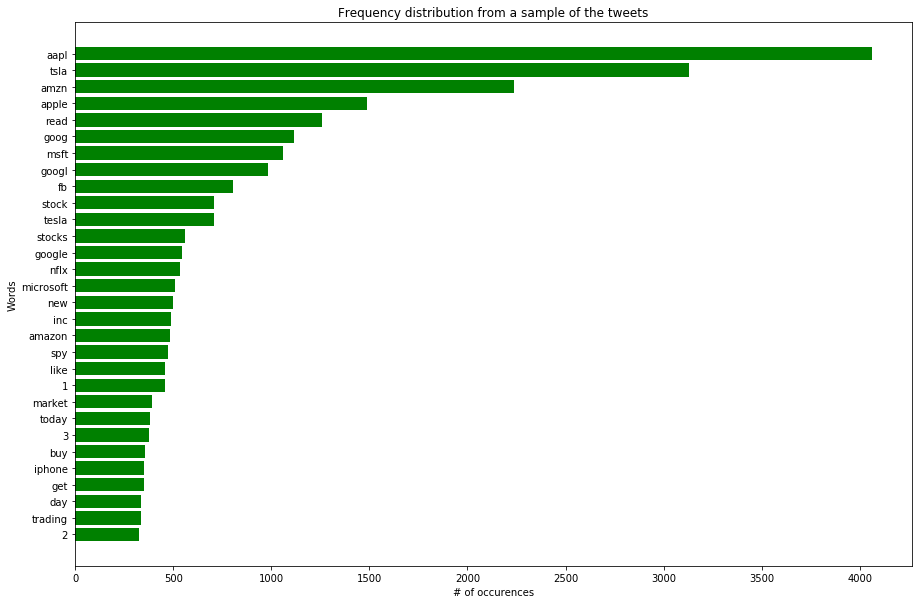

In [53]:
common_words = np.flip(common_words, axis=0)
bar_words = common_words[:, 0]
bar_occu = common_words[:, 1].astype(int)
bar_x = [i for i, _ in enumerate(bar_words)]

plt.figure(figsize=(15, 10))
plt.barh(bar_x, bar_occu, color='green')
plt.xlabel("# of occurences")
plt.ylabel("Words")
plt.title("Frequency distribution from a sample of the tweets")

plt.yticks(bar_x, bar_words)

plt.show()

The first 30 words consist mainly of companies' names and stock ticks as we can expect. But at the bottom there we can see words like \"like\" and "buy". This is very important, because they express some sort of sentiment.

### 4. Hypotheses

There are two main ways that social media could affect the market.
   1. The overall **amount of tweets** about a company raises the interest in its stocks, which results into more transactions being made (positions being closed and opened). The metric which tracks how much a stock is being traded is called **"Trading Volume"**. We can look for a correlation between the traded volume of a stock and how much people "talked" about it the previous day. 
       * The **null hypothesis** here is: There is *no correlation* between the amount of tweets about a company with the volume of its stock traded the following day.
       * And the **alternate hypothesis**: The *is a correlation* between the amount of tweets about a company with the volume of its stock traded the following day.


   2. Another important detail is what actually we're the people saying. In other words we would like to know if the general public opinion correlates in some way with the price's fluctuation. And what I mean by public opinion is whether the majority of the statements about a company made *online* are **positive or negative**. We will look at the correlation of the **average sentiment** of all tweets about a company and its **stock price** the following day.
       * **Null hypothesis**: There is *no correlation* between the ratio of positive/negative tweets about a company with the price of its stock on the same day.
       * And the **alternate hypothesis**: There *is a correlation* between the ratio of positive/negative tweets about a company with the price of its stock on the same day.

To test the our hypotheses we can use a correlation coefficient. The most common of these are the *Pearson correlation coefficient* and the *Spearman's rank correlation*. The first one is sensitive only to a linear relationship between two variables, which is not what we are looking for. The *Spearman's rank correlation coefficient* however is a lot more robust (sensitive to *non-linear relationships*) than Pearson's. That is why we will use it for this project.

### 5. Trading Volume and Amount of tweets

To look at the data for the individual stocks we first have to split the tweets dataset into different parts depending on what company they are about. We can create a function which does this for us, because will have to apply again later.

In [35]:
# Take the tickers which we have by looking at the unique values of the ticker_symbol column
tickers = tweets.ticker_symbol.unique().categories.tolist()

def split_by_ticker(df: pd.DataFrame):
    """  
    Split the dataframe into a list of dataframes based on the ticker_symbol column
    """
    return [df[df.ticker_symbol == ticker] for ticker in tickers]

tweets_by_company = split_by_ticker(tweets)

Now we want to group the tweet data based on the date of the tweet.

In [36]:
tweets_by_date = [t_by_company.groupby('date').size() for t_by_company in tweets_by_company]
tweets_by_date[0].head(5)

date
2015-01-01 00:00:57    1
2015-01-01 00:01:36    1
2015-01-01 00:10:05    3
2015-01-01 00:10:16    1
2015-01-01 00:10:17    3
dtype: int64

As we can see if we just group by the date column it also takes the time of day into account. We don't want that. To group only by the day we have to use a pandas Grouper class.

In [37]:
# The pandas Grouper class allows us to use a "freq" parameter which specifies
# the interval by which we would like to group our datetime objects
tweets_by_date = [t_by_company.groupby(pd.Grouper(key="date", freq="D")).size() for t_by_company in tweets_by_company]
tweets_by_date[0].head(5)

date
2015-01-01    280
2015-01-02    809
2015-01-03    231
2015-01-04    270
2015-01-05    891
Freq: D, dtype: int64

This gives us exactly what we want. We know which dataframe corresponds to which company by its index and the "ticks" list. Now we want to compare this data to the Volume of the given stock, again grouped by day.

Here after we split the data by ticker symbol just like we did for the tweets, we can simply remove all unnecessary columns, because the data is already given to us by date.

In [38]:
stocks_by_company = split_by_ticker(stocks)
stocks_by_company[0].head(6)

,ticker_symbol,date,volume,value
8589,AAPL,2015-01-02,212818400,27.59000
8590,AAPL,2015-01-05,257142000,26.81750
8591,AAPL,2015-01-06,263188400,26.60000
8592,AAPL,2015-01-07,160423600,26.86875
8593,AAPL,2015-01-08,237458000,27.64000
8594,AAPL,2015-01-09,214798000,28.08500


Let's get a Series (from the volume column with a date index), which we can plot a lot easier.

In [106]:
volume_stocks_by_date = [stock_by_company.set_index("date")["volume"] for stock_by_company in stocks_by_company]
volume_stocks_by_date[0].head(5)

date
2015-01-02    212818400
2015-01-05    257142000
2015-01-06    263188400
2015-01-07    160423600
2015-01-08    237458000
Name: volume, dtype: int64

Now we can plot the data and take a look at it.

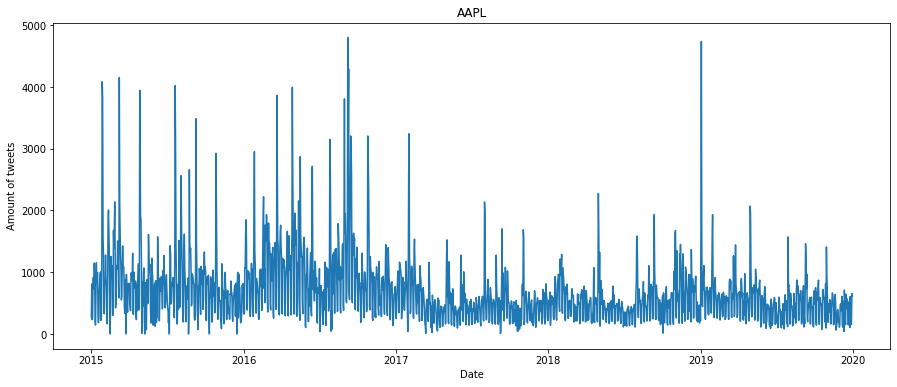

In [51]:
plt.figure(figsize=(15, 6))
plt.plot(tweets_by_date[0])
plt.title(tickers[0])
plt.xlabel("Date")
plt.ylabel("Amount of tweets")
plt.show()

As we can see the data differs a lot from day to day so maybe it would be more useful for us to plot it on a monthly basis.

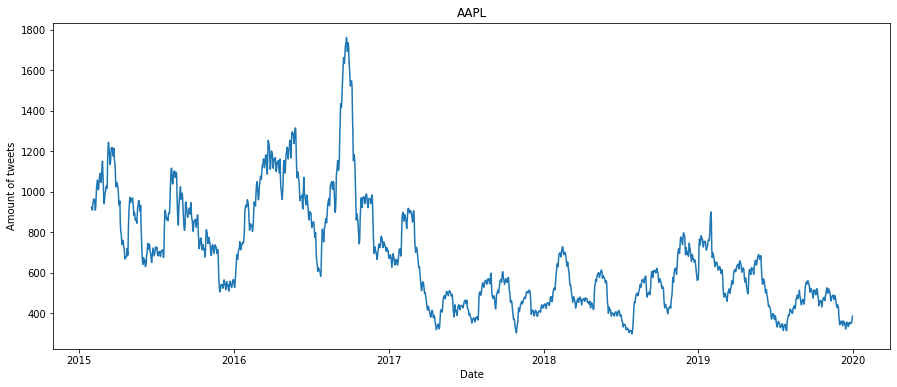

In [56]:
# Make the plot wider, so it is easier to read 
plt.figure(figsize=(15, 6))

# Get the mean of every 30 rows in our dataset and plot this instead of the data for every day.
tweets_by_month = tweets_by_date[0].rolling(30).mean()
plt.plot(tweets_by_month)

plt.title(tickers[0])

plt.xlabel("Date")
plt.ylabel("Amount of tweets")

plt.show()

Now we can see some trends a lot clearer. It's time to plot the traded volume against the tweet amount.

In [111]:
# for company_index in range(0, len(tickers)):
def plot_tweets(ticker):
    """
    Plot the mean amount of tweets for every 30 days for the given ticker
    """
    company_index = tickers.index(ticker)
        
    # Create a pyplot figure and add two axis to it, which share the same x coords.
    fig = plt.figure(figsize=(16, 8))
    ax_tweets = fig.add_subplot(label="Tweets")
    ax_stocks = ax_tweets.twinx()
    
    # Get the mean of every 30 rows in our dataset and plot this instead of the data for every day.
    tweets_by_month = tweets_by_date[company_index].rolling(30).mean()
    volume_stocks_by_month = volume_stocks_by_date[company_index].rolling(30).mean()
    
    ax_stocks.plot(volume_stocks_by_month, color="Orange", label="Stock Volume")
    ax_tweets.plot(tweets_by_month, label="Tweets Amount")
    
    ax_tweets.set_title(tickers[company_index])
    # Major ticks very 3 months.
    fmt_every_three_months = mdates.MonthLocator(interval=3)
    ax_tweets.xaxis.set_major_locator(fmt_every_three_months)
    
    # Format the major ticks to show the month name and year.
    ax_tweets.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    
    # Minor ticks every month
    fmt_month = mdates.MonthLocator()
    ax_tweets.xaxis.set_minor_locator(fmt_month)
    
    ax_tweets.set_xlabel("Date")
    ax_tweets.set_ylabel("Amount of tweets")
    ax_stocks.set_ylabel("Volume of the stock")
    
    lines, labels = ax_tweets.get_legend_handles_labels()
    lines2, labels2 = ax_stocks.get_legend_handles_labels()
    ax_stocks.legend(lines + lines2, labels + labels2, loc=0)
    
    # Auto format the xaxis labels so that there is enough room for them to be shown
    fig.autofmt_xdate()
    
    plt.show()

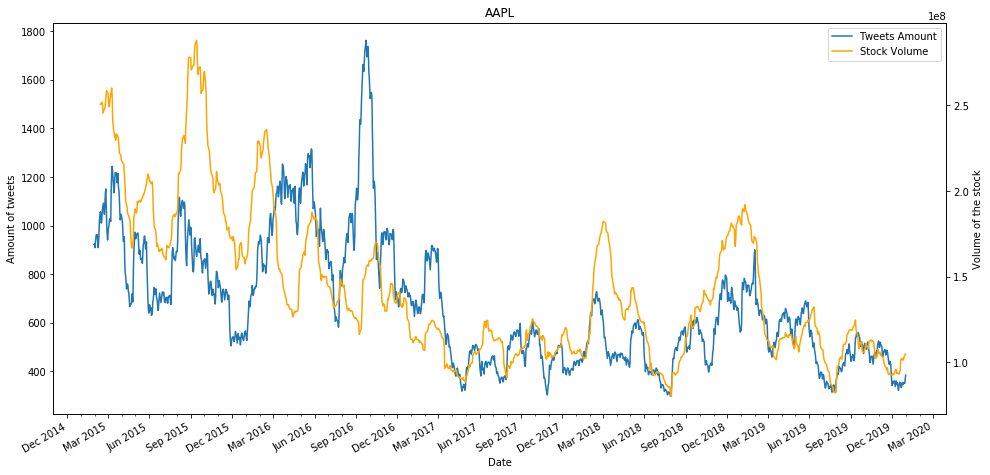

In [112]:
plot_tweets('AAPL')

We can see that there clearly is some correlation between the two variables, especially in the second half of the chart.

So now it is time to actually calculate the coefficient and test our hypothesis. We will combine the two series (`tweets_by_date` and `volume_stocks_by_date`) into one dataframe, on which we can later compute the correlation.

In [132]:
tweets_vs_volume = []
for company_index in range(0, len(tickers)):
    frame = {
        'tweets': tweets_by_date[company_index],
        'stocks': volume_stocks_by_date[company_index]
    }
    tweets_vs_volume.append(pd.DataFrame(frame))
tweets_vs_volume[0].head(10)

,tweets,stocks
date,,
2015-01-01,280,NaN
2015-01-02,809,212818400.0
2015-01-03,231,NaN
2015-01-04,270,NaN
2015-01-05,891,257142000.0
2015-01-06,917,263188400.0
2015-01-07,732,160423600.0
2015-01-08,1147,237458000.0
2015-01-09,892,214798000.0


As we can see the weekends here form a problem. The best thing we can do about them is to not look at them at all.

In [133]:
tweets_vs_volume = [t.dropna() for t in tweets_vs_volume]
tweets_vs_volume[0].head(10)

,tweets,stocks
date,,
2015-01-02,809,212818400.0
2015-01-05,891,257142000.0
2015-01-06,917,263188400.0
2015-01-07,732,160423600.0
2015-01-08,1147,237458000.0
2015-01-09,892,214798000.0
2015-01-12,667,198603200.0
2015-01-13,1152,268367600.0
2015-01-14,830,195826400.0


Now we can calculate the correlation using the pandas function `corr`.

In [141]:
tweets_vs_volume[0].corr(method="spearman"), stat.spearmanr(tweets_by_date[0].shift(-1).reindex(volume_stocks_by_date[0].index), volume_stocks_by_date[0], nan_policy="omit")

(          tweets    stocks
 tweets  1.000000  0.633796
 stocks  0.633796  1.000000,
 SpearmanrResult(correlation=0.38145013736852945, pvalue=8.261678705433715e-45))